# Import Libraries

In [32]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Fetch the Data

In [33]:
ticker = 'AAPL'  # Example ticker
data = yf.download(ticker, start='2020-01-01', end='2024-02-08')

[*********************100%%**********************]  1 of 1 completed


# Prep the Data

In [34]:
# Calculate 7-day and 14-day Moving Averages
data['7_day_MA'] = data['Close'].rolling(window=7).mean()
data['14_day_MA'] = data['Close'].rolling(window=14).mean()

# Calculate RSI (Relative Strength Index)
def RSI(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI'] = RSI(data['Close'])

# Drop rows with NaN values resulting from moving averages and RSI calculation
data.dropna(inplace=True)

In [35]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data[['Close', '7_day_MA', '14_day_MA', 'RSI']])
#scaled_data = scaler.fit_transform(data[['Close']])

# Convert to PyTorch tensors
scaled_data = torch.FloatTensor(scaled_data)

# Define sequence length and prepare data sequences
seq_length = 5


def create_sequences(input_data, seq_length):
    xs, ys = [], []
    for i in range(len(input_data)-seq_length):
        x = input_data[i:(i+seq_length)].tolist()  # Convert sequence to list
        y = input_data[i+seq_length][0]  # Assuming we want to predict the first feature
        xs.append(x)
        ys.append([y.item()])  # Ensure y is a list of scalar by calling .item()
    return torch.FloatTensor(xs), torch.FloatTensor(ys)

# Assuming 'scaled_data' is a 2D tensor where rows are samples and columns are features
X, y = create_sequences(scaled_data, seq_length)



# Model

In [36]:
class LSTMStockPredictor(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=100, output_size=1):
        super(LSTMStockPredictor, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]


# Training the Model

In [37]:
# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define model, loss function, and optimizer
model = LSTMStockPredictor()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
for epoch in range(epochs):
    for i in range(len(X_train)):
        model.zero_grad()
        y_pred = model(X_train[i])
        loss = loss_function(y_pred, y_train[i])
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} loss: {loss.item()}')


Epoch 0 loss: 0.003360630013048649
Epoch 10 loss: 0.0012173326686024666
Epoch 20 loss: 0.003181962063536048
Epoch 30 loss: 0.0027485147584229708
Epoch 40 loss: 0.002098571043461561
Epoch 50 loss: 0.0015478950226679444
Epoch 60 loss: 0.001350747887045145
Epoch 70 loss: 0.0013668660540133715
Epoch 80 loss: 0.0013546631671488285
Epoch 90 loss: 0.0014800807693973184


# Loss Calculation

In [38]:
model.eval()
predictions = []
with torch.no_grad():
    for i in range(len(X_test)):
        pred = model(X_test[i])
        predictions.append(pred.item())

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')


R-squared: -0.9645743150565824


# Plots

Predicted price: nan, Actual price: 189.41000366210938


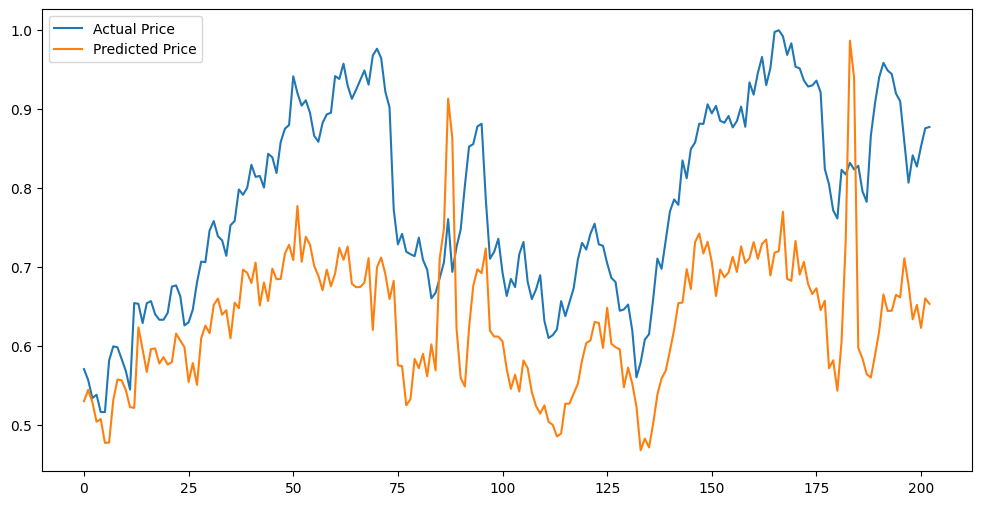

In [39]:
# Predict the last 'seq_length' days and compare with the actual data
with torch.no_grad():
    pred = model(X[-seq_length:])
    # Create an array with the same shape as the scaler expects
    pred_array = np.zeros((1, 4))  # Assuming there are 4 features
    pred_array[0, 0] = pred.item()  # Set the first feature to your predicted value
    predicted_price = scaler.inverse_transform(pred_array)[:, 0]  # Inverse transform and select the 'Close' price

actual_price = data['Close'].iloc[-1]
print(f'Predicted price: {predicted_price[0]}, Actual price: {actual_price}')

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.legend()
plt.show()
